# Имплементируем Граформер

У Майкрософта есть целый фреймворк Graphormer с разными утилитами для обучения и инференса этой модели. К сожалению, в нём сложно покопаться, потому что это не какая-нибудь питоновская либа, а просто набор скриптов. Так что я решил реализовать Graphormer самостоятельно.

Как мы знаем из статьи, по своей сути Graphormer - это просто трансформер, но с тремя значительными модификациями:
1. **Centrality Encoding** - добавляем к признакам вершин их меры центральности.
1. **Spatial Encoding** - к весам, получающимся в результате аттеншна, добавляем параметр, который зависит от расстояния между вершинами.
1. **Edge Encoding in the Attention** - в тот же аттеншн добавляем ещё результат вычисления некой функции от признаков рёбер на пути между вершинами.

Я реализовал трансформер с первыми двумя из этих модификаций. На Edge Encoding решил забить, во-первых, потому что там не очень тривиально закодить, а во-вторых, потому что признаки рёбер в принципе не так интересно. Получившуюся архитектуру назвал Dvoryaninormer (типа каламбур). Код [тут](https://github.com/Markfryazino/Dvoryaninormer). Код модельки маленький и довольно понятный, так что там можно посмотреть и на то, как можно реализовать конкретно эту модель, и на то, как в принципе без особых страданий реализовать статью по трансформерам.

 <img src="https://i.postimg.cc/s2rH6CVR/removal-ai-tmp-633b110f8a353.png" width=300 />

## Некоторые не очень стандартные детали реализации

1. В статье авторы пишут, что блок Graphormer отличается от ванильного трансформера тем, что Layer Norm тут применяется не после аттеншна, а до него. Это довольно важно и повсеместно (например, в GPT-2 то же самое).
1. Для того, чтобы получить эмбеддинг всего графа, а не только конкретных вершин, в граф добавляется фиктивная вершина `[VNode]`, которая "виртуально" связана со всеми. Фактически это можно сделать, просто добавив в матрицу признаков вершин дополнительный столбец, и всё.
```
    def _add_vnode(self, node_features, mask):
        batch_size, n_nodes, embedding_dim = node_features.size()
        vnode_embedding = self.vnode_embedding.repeat(batch_size, 1)
        return torch.cat([vnode_embedding.unsqueeze(1), node_features], dim=1), \
               torch.cat([torch.ones(batch_size, 1).to(mask.device), mask], dim=1)
```
1. Centrality Encoding тоже можно добавить в модель парой строчек кода. Для этого просто заводим эмбеддинг под центральности вершин и прибавляем выходы из него к фичам признаков.

    **__init__**:
    ```
    self.centrality_embedding = nn.Embedding(512, embedding_dim)
    ```

    **forward**:
    ```
    node_features += self.centrality_embedding(node_centralities.long())
    ```

1. Чтобы добавить Spatial Encoding, надо немного повозиться. Тут основная задача в том, чтобы подлезть в аттеншн и суметь добавить к его скорам смещение, получающееся из матрицы расстояний между вершинами.
```
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

    if shift is not None:
        scores += shift
```
Тут `shift` получается из матрицы с расстояниями между вершинами вот так:
```
result = self.path_length_embedding(distance_mat.long()).squeeze(-1)
```

Тоже, в принципе, не слишком сложно.

## Тест на маленьком датасете

Как оказалось, датасетов для graph representation в целом не то что бы много, и в основном они какие-то большие и про молекулы. Я скачал какой-то маленький датасет с классификацией на 100 классов и протестировал на нём, что всё работает.

In [ ]:
from IPython.display import clear_output
!git clone https://github.com/Markfryazino/Dvoryaninormer.git
!pip install wandb
clear_output()

%cd Dvoryaninormer

/content/Dvoryaninormer


In [ ]:
from src.data import load_coil_graphs
from src.training import train_dvoryanin
from sklearn.model_selection import train_test_split

coil_graphs, labels = load_coil_graphs(root="data/")

g_train, g_test, y_train, y_test = train_test_split(coil_graphs, labels, test_size=500, random_state=42, stratify=labels)

params = {
    "eval_steps": 100,
    "log_steps": 20,
    "epochs": 200,
    "batch_size": 64,
    "max_grad_norm": 3.,
    "model": {
        "node_dim": 64,
        "edge_dim": 1,
        "num_classes": 100,
        "embedding_dim": 64,
        "n_encoders": 3,
        "add_centrality_embedding": True,
        "add_path_length_embedding": True
    },
    "device": "cuda",
    "wandb": {
        "project": "Dvoryanin"
    }
}

_ = train_dvoryanin(g_train, y_train, g_test, y_test, params)

Adding centrality embedding
Adding path length embedding


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: broccoliman. Use `wandb login --relogin` to force relogin


  0%|          | 0/10800 [00:00<?, ?it/s]

TRAINING FINISHED. EVALUATING.
{'final_eval_accuracy': 0.968,
 'final_eval_loss': 0.1645011303424835,
 'final_train_accuracy': 0.9973529411764706,
 'final_train_loss': 0.010483785350533093}


adamw_learning_rate,▂▄▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval_accuracy,▁▁▁▃▅▅▆▇▇▇▇▇██▇█▇███████████████████████
eval_loss,█▇▇▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_eval_accuracy,▁
final_eval_loss,▁
final_train_accuracy,▁
final_train_loss,▁
train_loss,█▇▇▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
adamw_learning_rate,-0.0
epoch,199


Чего-то обучается и даже качество хорошее.

## А нужны ли модификации?

Теперь посмотрим на наглядный пример, зачем вообще нужны какие-то модификации трансформеру. Возьмём три разных графа и посмотрим, можем ли мы обучить модель их различать.

$G_1$ - цикл на 6 вершинах.

$G_2$ - цикл на 5 вершинах и изолированная вершина.

$G_3$ - два цикла на 3 вершинах.

In [ ]:
import networkx as nx
import torch

from src.data import CoilDataset, collate_graphs

def plot_graph(G, **kwargs):
    options = {
        "node_size": 1000,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 1,
        "width": 2,
    }
    options.update(kwargs)
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, **options, nodelist=G.nodes)

g1 = nx.Graph()
g2 = nx.Graph()
g3 = nx.Graph()

for i in range(6):
    g1.add_node(i, hist=[i])
    g2.add_node(i, hist=[i])
    g3.add_node(i, hist=[i])

for i in range(6):
    g1.add_edge(i, (i + 1) % 6)

for i in range(5):
    g2.add_edge(i, (i + 1) % 5)

for i in range(3):
    g3.add_edge(i, (i + 1) % 3)
    g3.add_edge(3 + i, 3 + (i + 1) % 3)


dataset = CoilDataset([g1, g2, g3], [0, 1, 2])
batch = collate_graphs([dataset[0], dataset[1], dataset[2]])
del batch["target"]

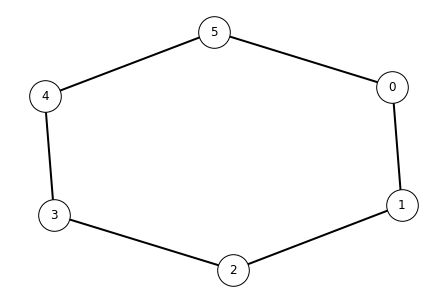

In [ ]:
plot_graph(g1, with_labels=True)

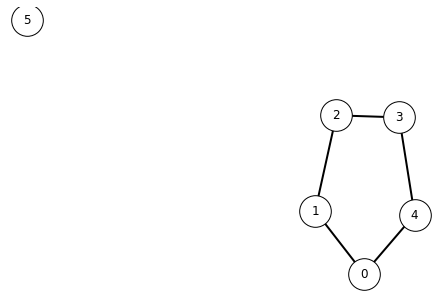

In [ ]:
plot_graph(g2, with_labels=True)

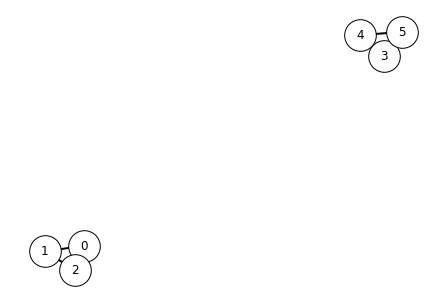

In [ ]:
plot_graph(g3, with_labels=True)

Будем сравнивать три модели:
1. Просто трансформер без Centrality Encoding и Spatial Encoding.
1. Модель с Centrality Encoding, но без Spatial Encoding.
1. Модель и с тем, и с другим.

Собственно, задача - попытаться классифицировать эти три графа.

In [ ]:
from src.training import dict_to_device

params = {
    "eval_steps": 100,
    "log_steps": 20,
    "epochs": 100,
    "batch_size": 3,
    "max_grad_norm": 3.,
    "model": {
        "node_dim": 1,
        "edge_dim": 1,
        "num_classes": 3,
        "embedding_dim": 64,
        "n_encoders": 2,
        "add_centrality_embedding": False,
        "add_path_length_embedding": False
    },
    "device": "cuda",
    "wandb": {
        "project": "Dvoryanin"
    }
}

dvoryanin1 = train_dvoryanin([g1, g2, g3], [0, 1, 2], [g1, g2, g3], [0, 1, 2], params)
dvoryanin1(**dict_to_device(batch))

  0%|          | 0/100 [00:00<?, ?it/s]

TRAINING FINISHED. EVALUATING.
{'final_eval_accuracy': 0.3333333333333333,
 'final_eval_loss': 1.098612387975057,
 'final_train_accuracy': 0.3333333333333333,
 'final_train_loss': 1.098612387975057}


adamw_learning_rate,▂▄▆▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval_accuracy,▁▁
eval_loss,█▁
final_eval_accuracy,▁
final_eval_loss,▁
final_train_accuracy,▁
final_train_loss,▁
train_loss,█▁▁▁▁
adamw_learning_rate,-1e-05
epoch,99


tensor([[-0.6875, -0.6880, -0.6879],
        [-0.6875, -0.6880, -0.6879],
        [-0.6875, -0.6880, -0.6879]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Что мы видим? Модель без модификаций не умеет различать графы с качеством > 1/3, потому что все три графа для неё эквивалентны. Это логично, так как модель вообще никак не учитывает графовую структуру.

In [ ]:
params["model"]["add_centrality_embedding"] = True
params["model"]["add_path_length_embedding"] = False

dvoryanin2 = train_dvoryanin([g1, g2, g3], [0, 1, 2], [g1, g2, g3], [0, 1, 2], params)
dvoryanin2(**dict_to_device(batch))

Adding centrality embedding


  0%|          | 0/100 [00:00<?, ?it/s]

TRAINING FINISHED. EVALUATING.
{'final_eval_accuracy': 0.6666666666666666,
 'final_eval_loss': 0.4621158440907796,
 'final_train_accuracy': 0.6666666666666666,
 'final_train_loss': 0.4621158440907796}


adamw_learning_rate,▂▄▆▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval_accuracy,▁█
eval_loss,█▁
final_eval_accuracy,▁
final_eval_loss,▁
final_train_accuracy,▁
final_train_loss,▁
train_loss,█▂▁▁▁
adamw_learning_rate,-1e-05
epoch,99


tensor([[ 3.8445, -6.8298,  3.8450],
        [-3.4914,  6.9391, -8.1855],
        [ 3.8445, -6.8298,  3.8450]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Включили Centrality Encoding и качество стало 2/3. Теперь модель умеет отличать $G_1$ от $G_2$, но всё ещё не умеет отличать $G_1$ от $G_3$ (потому что в обоих графах степени всех вершин равны 2).

Это правда, не значит, что наша моделька с Centrality Encoding такая уж тупая, потому что один из самых популярных способов хеширования графов Weisfeiler Lehman Kernel тоже не умеет отличать $G_1$ от $G_3$. Более того, стандартные версии Graph Convolutional Network тоже не справятся.

In [ ]:
params["model"]["add_centrality_embedding"] = True
params["model"]["add_path_length_embedding"] = True

dvoryanin3 = train_dvoryanin([g1, g2, g3], [0, 1, 2], [g1, g2, g3], [0, 1, 2], params)
dvoryanin3(**dict_to_device(batch))

Adding centrality embedding
Adding path length embedding


  0%|          | 0/100 [00:00<?, ?it/s]

TRAINING FINISHED. EVALUATING.
{'final_eval_accuracy': 1.0,
 'final_eval_loss': 0.0026092746605475745,
 'final_train_accuracy': 1.0,
 'final_train_loss': 0.0026092746605475745}


adamw_learning_rate,▂▄▆▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval_accuracy,▁█
eval_loss,█▁
final_eval_accuracy,▁
final_eval_loss,▁
final_train_accuracy,▁
final_train_loss,▁
train_loss,█▅▄▁▁
adamw_learning_rate,-1e-05
epoch,99


tensor([[  3.5007,  -2.3492,  -2.1995],
        [ -1.1594,   9.0946, -14.7029],
        [  1.5716,  -7.1433,   8.0173]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Включили Spatial Encoding и accuracy стало 1. Вот так вот, получилась хорошая экспрессивная модель.